In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('.')
sys.path.append('./scripts')

In [7]:
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 2.0

#### Feature Ranking

In [8]:
methods = [
    'lmdi+',    
    'lmdi',
    'LIME',
    'Treeshap',
]
color_map = {
    'LIME': '#71BEB7',
    'Treeshap': 'orange',
    'lmdi': '#9B5DFF',
    'lmdi+': 'black'
}

data_name = {
    "openml_361260": "Miami Housing",
    "openml_361259": "Puma Robot",
    "openml_361253": "Wave Energy",
    "openml_361254": "SARCOS",
    "openml_361242": "Super Conductivity",
    "openml_361243": "Geographic Origin of Music",
    "openml_43": "Spam",
    "openml_361062": "Pol",
    "openml_361071": "Jannis",
    "openml_9978": "Ozone",
    "openml_361069": "Higgs",
    "openml_361063": "House 16H"
}

feature_values = {
    "openml_361260": 15,
    "openml_361259": 32,
    "openml_361253": 48,
    "openml_361254": 21,
    "openml_361242": 81,
    "openml_361243": 72,
    "openml_43": 57,
    "openml_361062": 26,
    "openml_361071": 54,
    "openml_9978": 47,
    "openml_361069": 24,
    "openml_361063": 16
}

methods_name = {
    'LIME': 'LIME',
    'lmdi': 'LMDI',
    'Treeshap': 'TreeSHAP',
    'lmdi+': 'LMDI+',
}

data_generator_label_map = {
    'linear': 'Linear',
    'interaction': 'Interaction',
    'linear_lss': 'Linear + LSS',
    'logistic_linear': 'Logistic',
    'logistic_interaction': 'Logistic Interaction',
    'logistic_linear_lss': 'Logistic + LSS'

}

In [9]:
combined_df = pd.DataFrame()
datasets = ["openml_361259"]
for dgp in ["linear", "interaction", "linear_lss"]:
    for data in datasets:
        ablation_directory = f"./results_new/mdi_local.real_data_regression_{data}_{dgp}/{data}_{dgp}/varying_heritability_sample_row_n"
        feature_seeds = [1,2,3,4,5,6,7,8,9,10]
        sample_seeds = [1,2,3]
        for sample_seed in sample_seeds:
            for feature_seed in feature_seeds:
                df = pd.read_csv(os.path.join(ablation_directory, f"seed_{feature_seed}_{sample_seed}/results.csv"))
                df["data"] = data
                df["dgp"] = dgp
                combined_df = pd.concat([combined_df, df], ignore_index=True)

agg_df = combined_df.groupby(['sample_row_n', 'heritability','dgp', 'fi', 'data'])[
    ["auroc_train", "auroc_test"]
].agg(['mean', 'std', 'count']).reset_index()
agg_df.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in agg_df.columns.values]
agg_df["auroc_train_sem"] = agg_df["auroc_train_std"] / np.sqrt(agg_df["auroc_train_count"])
agg_df["auroc_test_sem"] = agg_df["auroc_test_std"] / np.sqrt(agg_df["auroc_test_count"])
df_regression = agg_df[agg_df["sample_row_n"] == 1000]

In [10]:
combined_df = pd.DataFrame()
datasets = ["openml_361069"]
for dgp in ["logistic_linear", "logistic_interaction", "logistic_linear_lss"]:
    for data in datasets:
        ablation_directory = f"./results_new/mdi_local.real_data_classification_{data}_{dgp}/{data}_{dgp}/varying_frac_label_corruption_sample_row_n"
        feature_seeds = [1,2,3,4,5,6,7,8,9,10]
        sample_seeds = [1,2,3]
        for sample_seed in sample_seeds:
            for feature_seed in feature_seeds:
                df = pd.read_csv(os.path.join(ablation_directory, f"seed_{feature_seed}_{sample_seed}/results.csv"))
                df["data"] = data
                df["dgp"] = dgp
                combined_df = pd.concat([combined_df, df], ignore_index=True)

agg_df = combined_df.groupby(['sample_row_n', 'frac_label_corruption','dgp', 'fi', 'data'])[
    ["auroc_train", "auroc_test"]
].agg(['mean', 'std', 'count']).reset_index()
agg_df.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in agg_df.columns.values]
agg_df["auroc_train_sem"] = agg_df["auroc_train_std"] / np.sqrt(agg_df["auroc_train_count"])
agg_df["auroc_test_sem"] = agg_df["auroc_test_std"] / np.sqrt(agg_df["auroc_test_count"])
df_classification = agg_df[agg_df["sample_row_n"] == 1000]

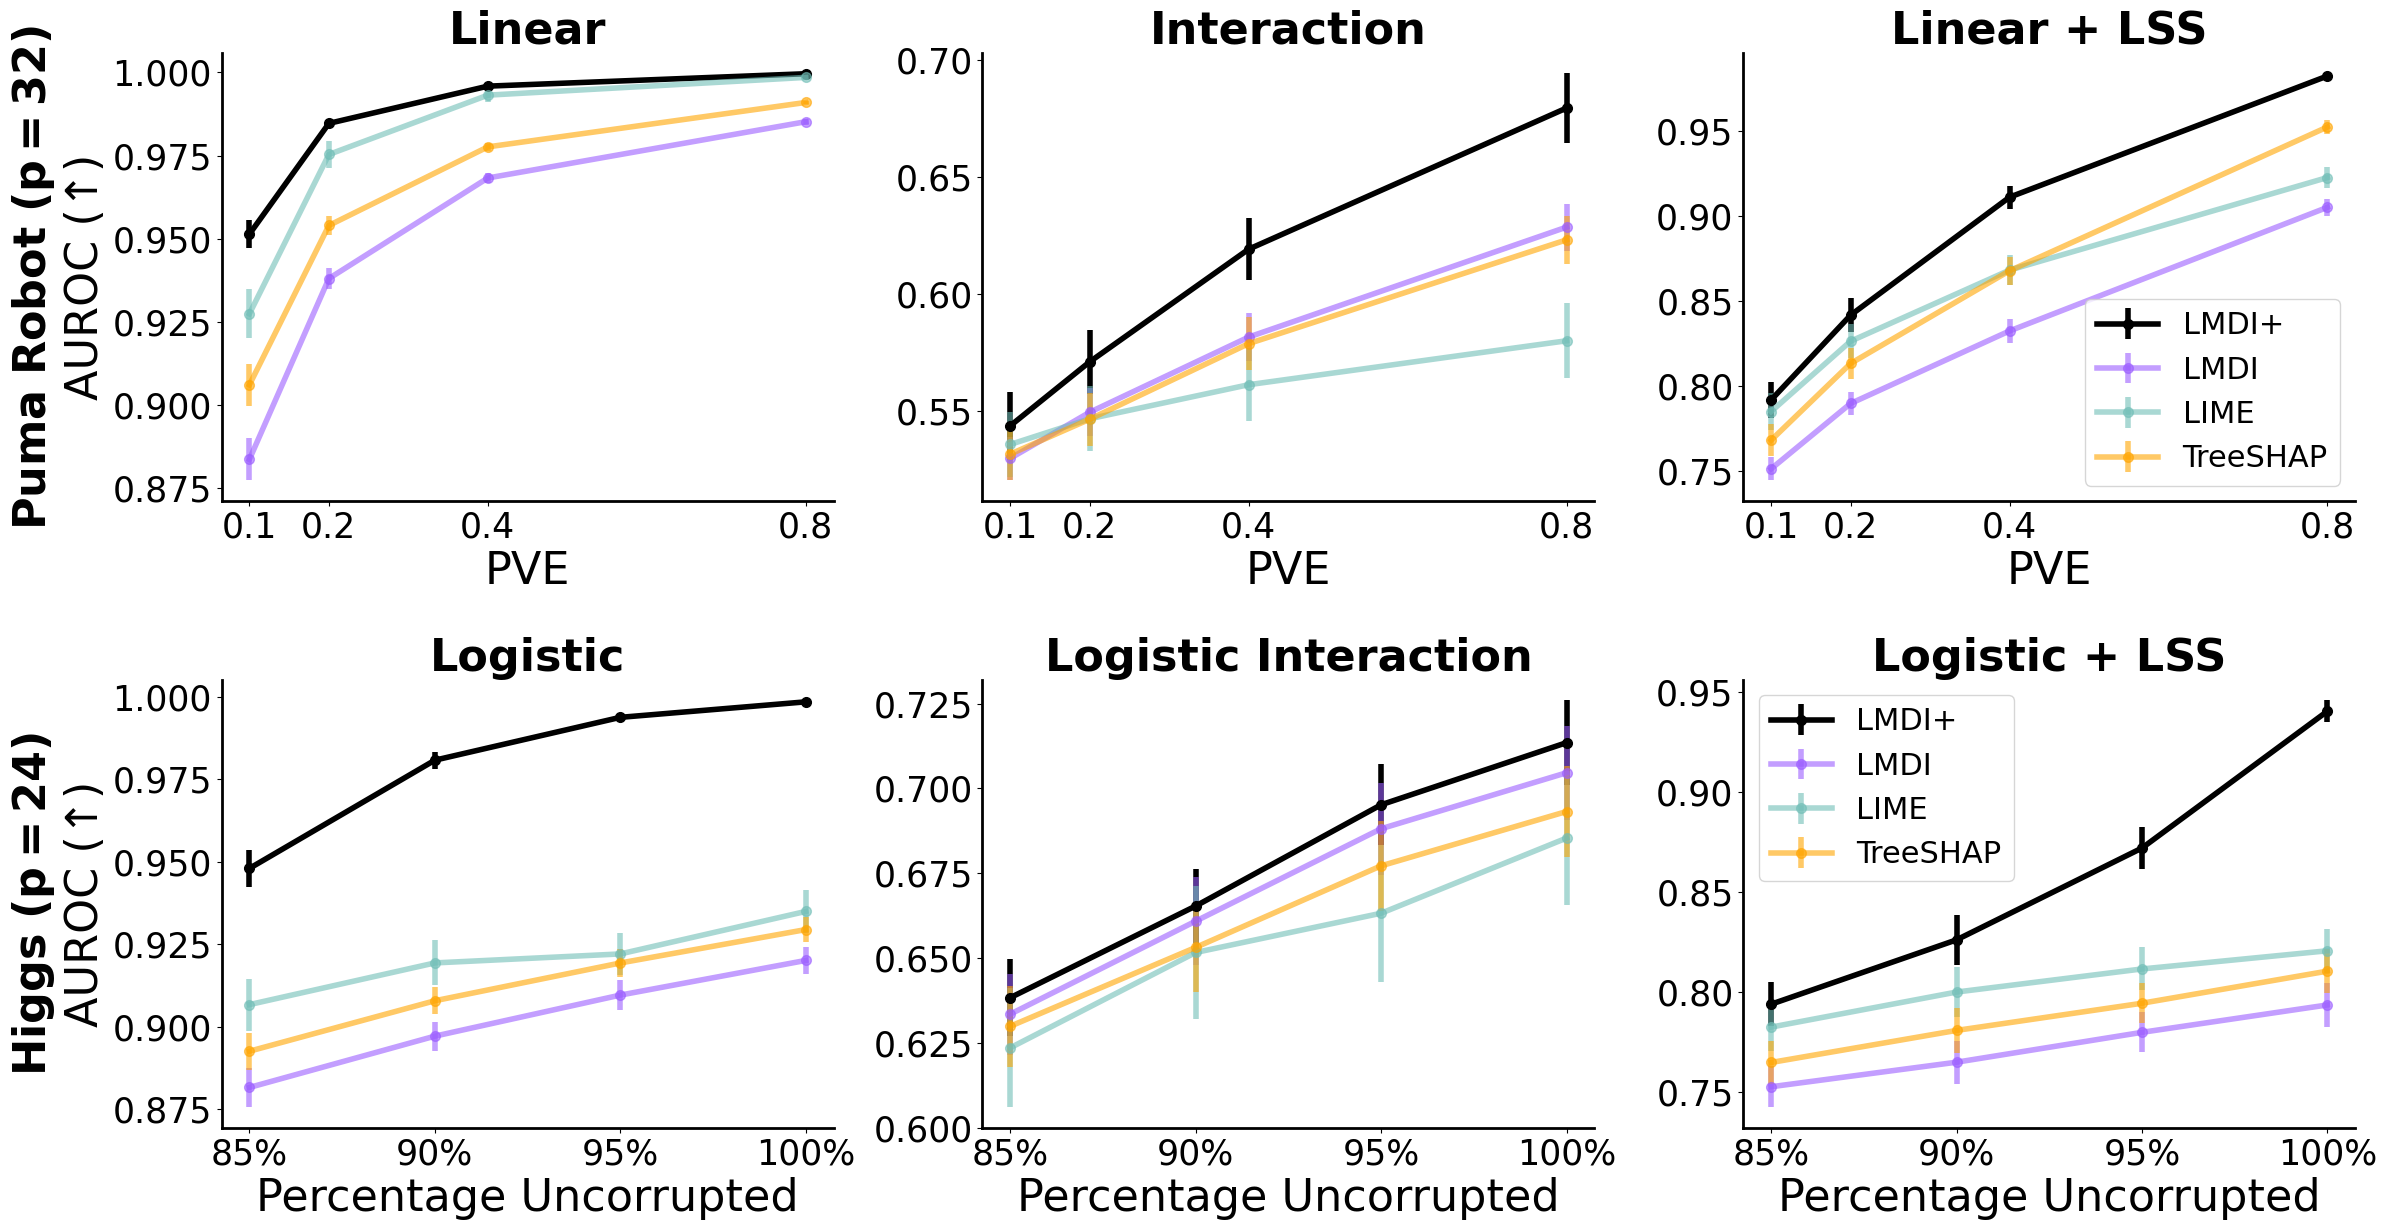

In [11]:
regression_datasets = df_regression["data"].unique()
classification_datasets = df_classification["data"].unique()
regression_dgp = ['linear', 'interaction', 'linear_lss']
classification_dgp = ['logistic_linear', 'logistic_interaction', 'logistic_linear_lss']
marker_size = 7

n_cols = 3
n_rows = 2
fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(8 * n_cols, 6.2 * n_rows),
    sharey=False
)

if n_rows == 1:
    axs = np.expand_dims(axs, axis=0)
if n_cols == 1:
    axs = np.expand_dims(axs, axis=1)

for row_idx, dataset in enumerate(regression_datasets):
    for col_idx, data_generator in enumerate(regression_dgp):
        ax = axs[row_idx, col_idx]
        subset = df_regression[(df_regression["data"] == dataset) & (df_regression["dgp"] == data_generator)]
        
        for method in methods:
            method_data = subset[subset["fi"] == method]
            if method in ['LIME', 'Treeshap', 'lmdi']:
                ax.errorbar(
                    method_data["heritability"], method_data['auroc_test_mean'], yerr=method_data["auroc_test_sem"],
                    linestyle='solid', marker='o', markersize=marker_size,
                    label=methods_name[method], color=color_map[method], linewidth=4, alpha=0.6
                )
            else:
                ax.errorbar(
                    method_data["heritability"], method_data['auroc_test_mean'], yerr=method_data["auroc_test_sem"],
                    linestyle='solid', marker='o', markersize=marker_size,
                    label=methods_name[method], color=color_map[method], linewidth=4
                )
        ax.set_xticks([0.1, 0.2, 0.4, 0.8])
        ax.set_xticklabels(["0.1", "0.2", "0.4", "0.8"], fontsize=25)
        ax.tick_params(axis='y', labelsize=25)
        ax.set_xlabel("PVE", fontsize=32)
        if col_idx == 0:
            dataset_label = data_name[dataset].replace(' ', r'\ ')
            p_val = feature_values[dataset]
            ax.set_ylabel(f"$\\mathbf{{{dataset_label}\ (p={p_val})}}$\nAUROC (↑)", fontsize=32)
        if row_idx == 0:
            ax.set_title(f"{data_generator_label_map[data_generator]}", fontsize=32, fontweight='bold')
        if col_idx == n_cols - 1:
            ax.legend(fontsize=22, loc='lower right')

for row_idx, dataset in enumerate(classification_datasets, start=len(regression_datasets)):
    for col_idx, data_generator in enumerate(classification_dgp):
        ax = axs[row_idx, col_idx]
        subset = df_classification[(df_classification["data"] == dataset) & (df_classification["dgp"] == data_generator)]
        
        for method in methods:
            method_data = subset[subset["fi"] == method]
            if method in ['LIME', 'Treeshap', 'lmdi']:
                ax.errorbar(
                    method_data["frac_label_corruption"], method_data['auroc_test_mean'], yerr=method_data["auroc_test_sem"],
                    linestyle='solid', marker='o', markersize=marker_size,
                    label=methods_name[method], color=color_map[method], linewidth=4, alpha=0.6
                )
            else:
                ax.errorbar(
                    method_data["frac_label_corruption"], method_data['auroc_test_mean'], yerr=method_data["auroc_test_sem"],
                    linestyle='solid', marker='o', markersize=marker_size,
                    label=methods_name[method], color=color_map[method], linewidth=4
                )
        ax.set_xticks([0.15, 0.1, 0.05, 0])
        ax.set_xticklabels(["85%", "90%", "95%", "100%"], fontsize=25)
        ax.invert_xaxis()
        ax.tick_params(axis='y', labelsize=25)
        ax.set_xlabel("Percentage Uncorrupted", fontsize=32)
        if col_idx == 0:
            dataset_label = data_name[dataset].replace(' ', r'\ ')
            p_val = feature_values[dataset]
            ax.set_ylabel(f"$\\mathbf{{{dataset_label}\ (p={p_val})}}$\nAUROC (↑)", fontsize=32)
        if row_idx == len(regression_datasets):
            ax.set_title(f"{data_generator_label_map[data_generator]}", fontsize=32, fontweight='bold')
        if col_idx == n_cols - 1:
            ax.legend(fontsize=22, loc='upper left')
plt.tight_layout(rect=[0, 0, 1, 1])
plt.subplots_adjust(hspace=0.4)
#plt.savefig("main_paper_feature_ranking.pdf", format='pdf', bbox_inches='tight')
plt.show()

### Stability

In [12]:
task = "regression" 
combined_df = pd.DataFrame()
datasets = ["openml_361254", "openml_361259"]
for data in datasets:
    ablation_directory =f"./results_new/mdi_local.real_data_{task}_{data}_stability/{data}_stability/varying_sample_row_n"
    split_seeds = [1,2,3]
    sample_seeds = [1,2,3,4,5]
    for split_seed in split_seeds:
        for sample_seed in sample_seeds:
            df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{sample_seed}/results.csv"))
            df["data"] = data
            combined_df = pd.concat([combined_df, df], ignore_index=True)
df_regression = combined_df[combined_df["sample_row_n"] == 2000]

task = "classification" 
datasets = ["openml_361069", "openml_9978"]
combined_df = pd.DataFrame()
for data in datasets:
    ablation_directory =f"./results_new/mdi_local.real_data_{task}_{data}_stability/{data}_stability/varying_sample_row_n"
    split_seeds = [1,2,3]
    sample_seeds = [1,2,3,4,5]
    for split_seed in split_seeds:
        for sample_seed in sample_seeds:
            df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{sample_seed}/results.csv"))
            df["data"] = data
            combined_df = pd.concat([combined_df, df], ignore_index=True)
df_classification = combined_df[combined_df["sample_row_n"] == 2000]

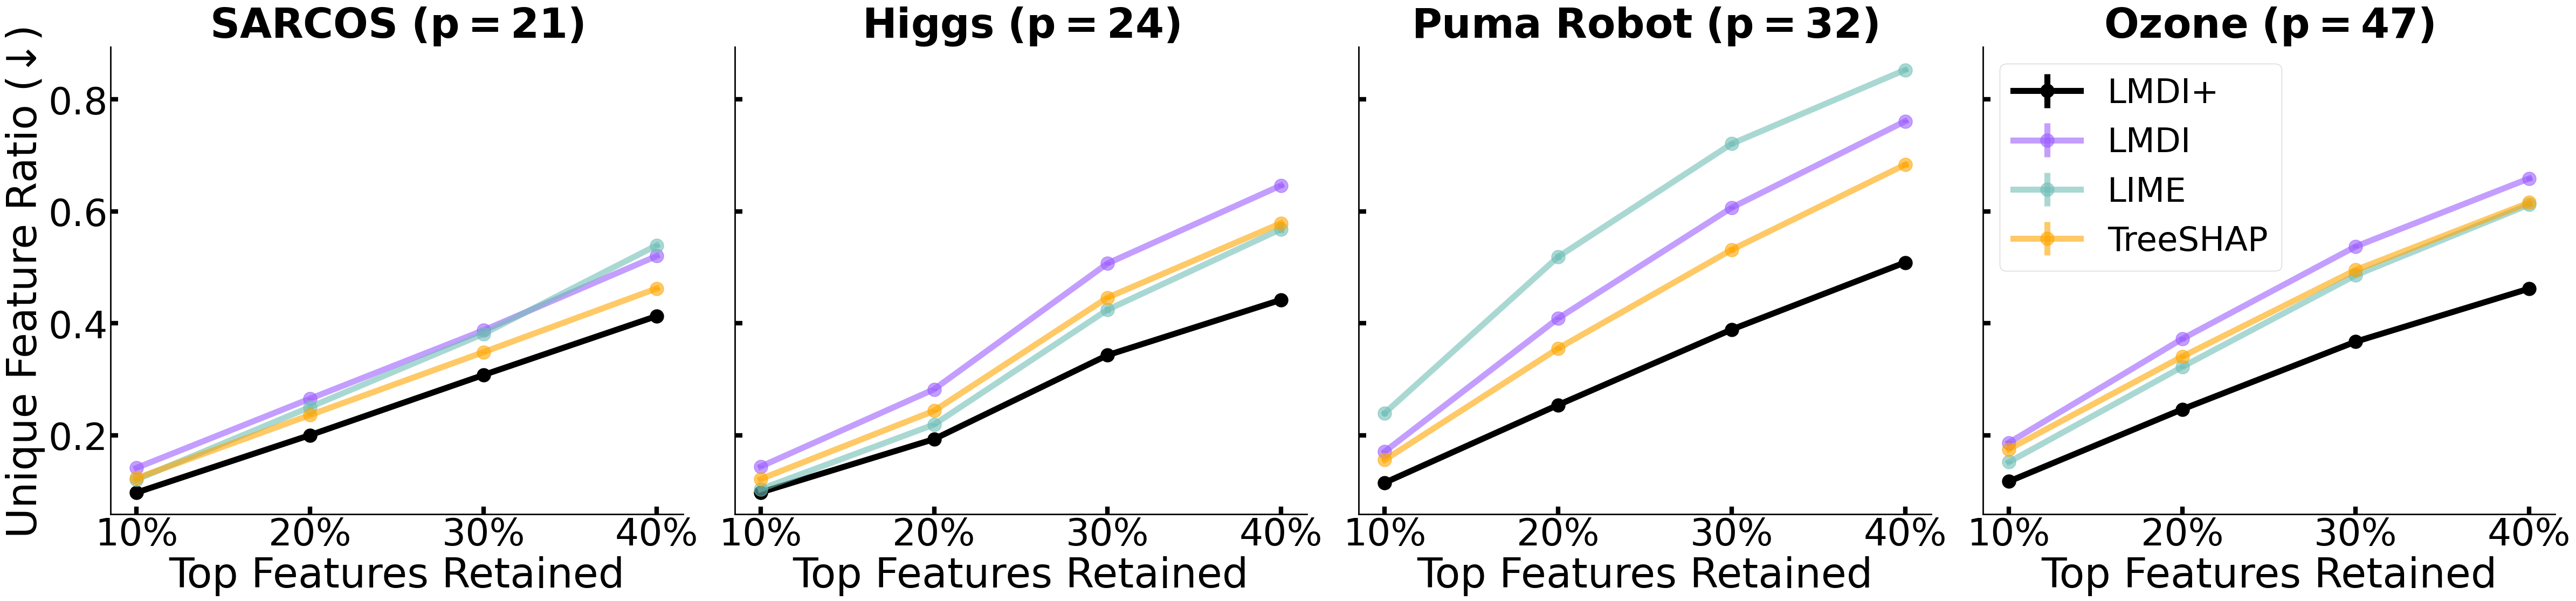

In [13]:
regression_datasets = list(df_regression["data"].unique())
classification_datasets = list(df_classification["data"].unique())

marker_size = 18
n_rows = 1
n_cols = 4

fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(12 * n_cols, 11.25 * n_rows),
    sharey=True
)
axs = axs.flatten()

plot_order = [
    ("regression", regression_datasets[0]),
    ("classification", classification_datasets[0]),
    ("regression", regression_datasets[1]),
    ("classification", classification_datasets[1]),
]

for plot_idx, (dtype, dataset) in enumerate(plot_order):
    ax = axs[plot_idx]
    subset = df_regression if dtype == "regression" else df_classification
    subset = subset[subset["data"] == dataset]

    for method in methods:
        method_data = subset[subset["fi"] == method]

        x = [0.1, 0.2, 0.3, 0.4]
        cols = ["avg_10_features", "avg_20_features", "avg_30_features", "avg_40_features"]
        
        n_features = feature_values[dataset]
        normalized_data = method_data[cols] / n_features
        
        means = normalized_data.mean(axis=0).values
        stds = normalized_data.std(axis=0).values
        counts = normalized_data.count(axis=0).values
        sems = stds / np.sqrt(counts)

        if method in ['LIME', 'Treeshap', 'lmdi']:
            ax.errorbar(
                x, means, sems,
                linestyle='solid', marker='o', markersize=marker_size,
                label=methods_name[method], color=color_map[method], linewidth=8, alpha=0.6
            )
        else:
            ax.errorbar(
                x, means, sems,
                linestyle='solid', marker='o', markersize=marker_size,
                label=methods_name[method], color=color_map[method], linewidth=8
            )

    ax.set_xticks([0.1, 0.2, 0.3, 0.4])
    ax.set_xticklabels(["10%", "20%", "30%", "40%"], fontsize=50)
    ax.tick_params(axis='both', which='both', direction='in', length=10, width=6, labelsize=50)
    ax.set_xlabel("Top Features Retained", fontsize=55)
    if plot_idx == 0:
        ax.set_ylabel("Unique Feature Ratio (↓)", fontsize=55)
    dataset_label = data_name[dataset].replace(' ', r'\ ')
    p_val = feature_values[dataset]
    ax.set_title(f"$\\mathbf{{{dataset_label} \ (p={p_val}) }}$", fontsize=55)

axs[-1].legend(fontsize=45, loc='upper left')

plt.tight_layout()
#plt.savefig("main_paper_feature_stability.pdf", format='pdf', bbox_inches='tight')
plt.show()


### Feature Selection

In [14]:
task = "regression" 
combined_df = pd.DataFrame()
datasets = ["openml_361254", "openml_361259"]
for data in datasets:
    ablation_directory =f"./results_new/mdi_local.real_data_{task}_{data}/{data}_selection/varying_sample_row_n"
    split_seeds = [1,2,3,4]
    sample_seeds = [1,2,3,4,5]
    for split_seed in split_seeds:
        for sample_seed in sample_seeds:
            df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{sample_seed}/results.csv"))
            df["data"] = data
            combined_df = pd.concat([combined_df, df], ignore_index=True)
df_regression = combined_df

task = "classification" 
datasets = ["openml_361069", "openml_9978"]
combined_df = pd.DataFrame()
for data in datasets:
    ablation_directory =f"./results_new/mdi_local.real_data_{task}_{data}/{data}_selection/varying_sample_row_n"
    split_seeds = [1,2,3,4]
    sample_seeds = [1,2,3,4,5]
    for split_seed in split_seeds:
        for sample_seed in sample_seeds:
            df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{sample_seed}/results.csv"))
            df["data"] = data
            combined_df = pd.concat([combined_df, df], ignore_index=True)
df_classification = combined_df

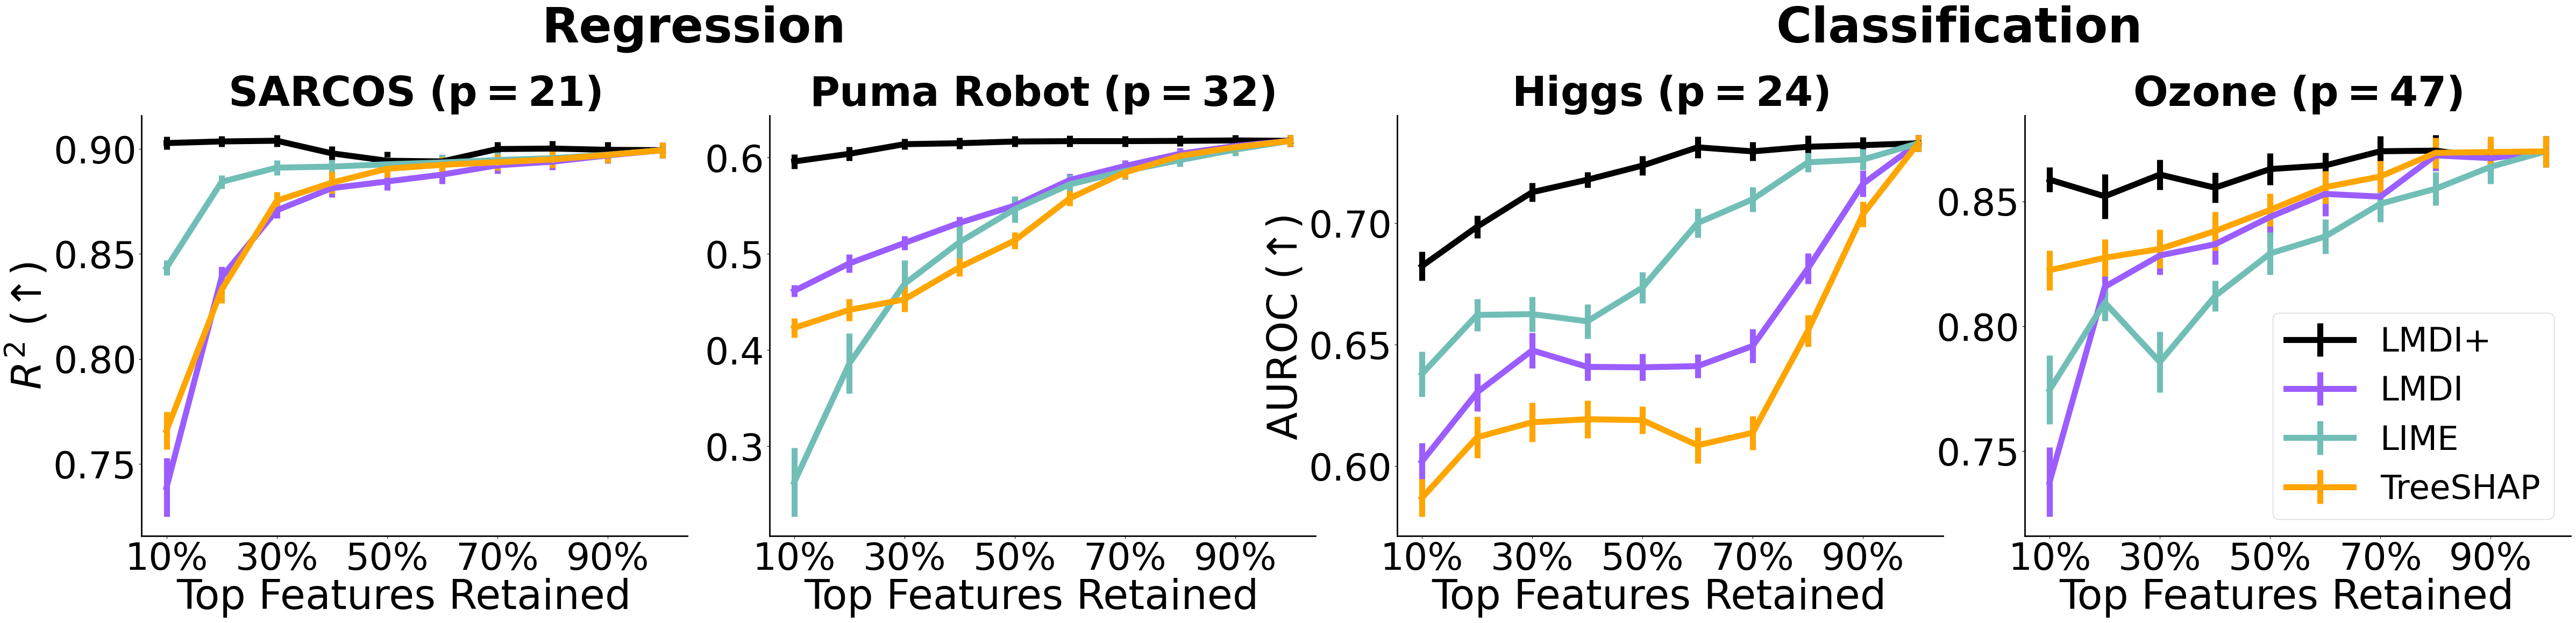

In [15]:
regression_datasets = df_regression["data"].unique()
classification_datasets = df_classification["data"].unique()
marker_size = 7
n_rows = 1
n_cols = 4

fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(12 * n_cols, 12 * n_rows),
    sharey=False
)
axs = axs.flatten()

for plot_idx, dataset in enumerate(regression_datasets):
    ax = axs[plot_idx]
    subset = df_regression[(df_regression["data"] == dataset)]

    for method in methods:
        method_data = subset[subset["fi"] == method]


        r2_col = ["RF_Regressor_R2_keep_0.1", "RF_Regressor_R2_keep_0.2", "RF_Regressor_R2_keep_0.3",
            "RF_Regressor_R2_keep_0.4", "RF_Regressor_R2_keep_0.5", "RF_Regressor_R2_keep_0.6", "RF_Regressor_R2_keep_0.7",
            "RF_Regressor_R2_keep_0.8", "RF_Regressor_R2_keep_0.9", "RF_Regressor_R2_keep_1.0"]
        means = method_data[r2_col].mean(axis=0).values
        stds = method_data[r2_col].std(axis=0).values
        counts = method_data[r2_col].count(axis=0).values
        sems = stds / np.sqrt(counts)
        x = [0.1, 0.2, 0.3, 0.4,0.5,0.6,0.7,0.8,0.9,1.0]

        if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI', 'MDI+']:
            ax.errorbar(
                x, means, sems,
                label=methods_name[method], linestyle='solid',
                marker='o', markersize=marker_size, color=color_map[method], linewidth=8, alpha=0.6
            )
        else:
            ax.errorbar(
                x, means, sems,
                label=methods_name[method], linestyle='solid',
                marker='o', markersize=marker_size, color=color_map[method], linewidth=8
            )

    ax.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
    ax.set_xticklabels(["10%", "30%", "50%", "70%", "90%"], fontsize=50)
    ax.tick_params(axis='y', labelsize=50)
    ax.set_xlabel("Top Features Retained", fontsize=55)
    ax.xaxis.set_label_coords(0.48, -0.1)
    if plot_idx == 0:
        ax.set_ylabel(f"$R^2$ (↑)", fontsize=55)
    dataset_label = data_name[dataset].replace(' ', r'\ ')
    p_val = feature_values[dataset]
    ax.set_title(f"$\\mathbf{{{dataset_label} \ (p={p_val}) }}$", fontsize=55)


for plot_idx, dataset in enumerate(classification_datasets, start=2):
    ax = axs[plot_idx]
    subset = df_classification[(df_classification["data"] == dataset)]

    for method in methods:
        method_data = subset[subset["fi"] == method]

        auroc_cols = [
            "RF_Classifier_AUROC_keep_0.1", "RF_Classifier_AUROC_keep_0.2", "RF_Classifier_AUROC_keep_0.3",
            "RF_Classifier_AUROC_keep_0.4", "RF_Classifier_AUROC_keep_0.5", "RF_Classifier_AUROC_keep_0.6",
            "RF_Classifier_AUROC_keep_0.7", "RF_Classifier_AUROC_keep_0.8", "RF_Classifier_AUROC_keep_0.9",
            "RF_Classifier_AUROC_keep_1.0"
        ]
        means = method_data[auroc_cols].mean(axis=0).values
        stds = method_data[auroc_cols].std(axis=0).values
        counts = method_data[auroc_cols].count(axis=0).values
        sems = stds / np.sqrt(counts)

        x = [0.1, 0.2, 0.3, 0.4,0.5,0.6,0.7,0.8,0.9,1.0]

        if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI', 'MDI+']:
            ax.errorbar(
                x, means, sems,
                label=methods_name[method], linestyle='solid',
                marker='o', markersize=marker_size, color=color_map[method], linewidth=8, alpha=0.6
            )
        else:
            ax.errorbar(
                x, means, sems,
                label=methods_name[method], linestyle='solid',
                marker='o', markersize=marker_size, color=color_map[method], linewidth=8
            )

    ax.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
    ax.set_xticklabels(["10%", "30%", "50%", "70%", "90%"], fontsize=50)
    ax.tick_params(axis='y', labelsize=50)
    ax.set_xlabel("Top Features Retained", fontsize=55)
    ax.xaxis.set_label_coords(0.48, -0.1)
    if plot_idx == 2:
        ax.set_ylabel(f"AUROC (↑)", fontsize=55)
    dataset_label = data_name[dataset].replace(' ', r'\ ')
    p_val = feature_values[dataset]
    ax.set_title(f"$\\mathbf{{{dataset_label} \ (p={p_val}) }}$", fontsize=55)

axs[-1].legend(fontsize=45, loc='lower right')

fig.text(0.27, 0.9, "Regression", ha='center', va='bottom', fontsize=65, fontweight='bold')
fig.text(0.76, 0.9, "Classification", ha='center', va='bottom', fontsize=65, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.subplots_adjust(wspace=0.15)
#plt.savefig("main_paper_feature_selection.pdf", format='pdf', bbox_inches='tight')
plt.show()
